In [3]:
from diffusers import LDMSuperResolutionPipeline
from diffusers.pipelines.latent_diffusion.pipeline_latent_diffusion_superresolution import preprocess

from dataset import CoverDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from models import get_models
import albumentations as A
import torch
from defs import *
from diffusers import DDPMScheduler, DDPMPipeline
from evaluate import evaluate, make_grid
import numpy as np
from minepi import Skin
from PIL import Image


/root/anaconda3/envs/album/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Definding seed and device

In [4]:
DEVICE = 'cuda:0'
SEED = 100231
MODEL_PATH = "results_2attention/weights/unet"

## Getting Diffusion model

In [5]:
model = get_models(IMSIZE).to(DEVICE)
model = model.from_pretrained(MODEL_PATH)
model.sample_size = 64
model = model.to(DEVICE)
model.eval()
noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TRAIN_TIMESTEPS)

pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)
generator = torch.Generator(device=DEVICE)
generator = generator.manual_seed(SEED)

## Generate 128x128 images

In [13]:
images = pipeline(
    batch_size=2,
    generator=generator,
    output_type=None
).images

100%|██████████| 1000/1000 [00:22<00:00, 43.76it/s]


(-0.5, 188.5, 402.5, -0.5)

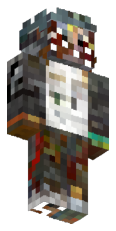

In [71]:
d = True
s = Skin(raw_skin=Image.fromarray((images[idx]*255).astype('uint8')))
await s.render_skin(display_hair=d, display_second_layer=d, display_cape=d)
plt.imshow(s.skin)
plt.axis('off')

In [72]:
images[idx][:,:,-1] = images[idx][:,:,-1]>0.5


(-0.5, 188.5, 399.5, -0.5)

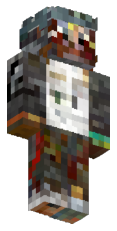

In [73]:
d = True
s = Skin(raw_skin=Image.fromarray((images[idx]*255).astype('uint8')))
await s.render_skin(display_hair=d, display_second_layer=d, display_cape=d)
plt.imshow(s.skin)
plt.axis('off')

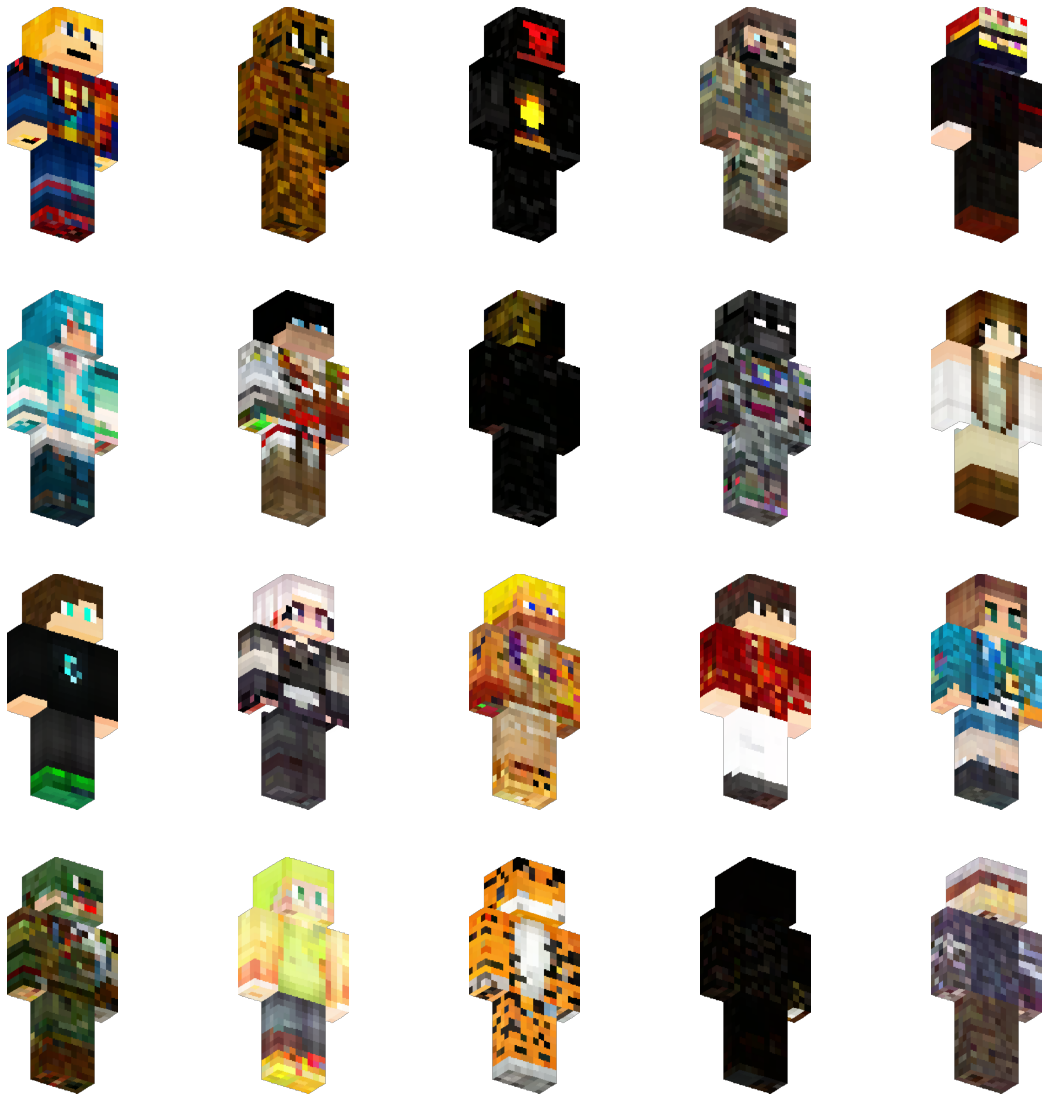

In [10]:
plt.figure(figsize=(20, 20))
d = False
for idx, i in enumerate(images):
    s = Skin(raw_skin=i)
    await s.render_skin(display_hair=d, display_second_layer=d, display_cape=d)
    plt.subplot(4,5, idx+1)
    plt.imshow(s.skin)
    plt.axis('off')

## Getting Super Resolution model

In [5]:
rescaler_id = "CompVis/ldm-super-resolution-4x-openimages"
rescaler = LDMSuperResolutionPipeline.from_pretrained(rescaler_id)
rescaler = rescaler.to(DEVICE)

Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 7037.42it/s]


## Upscale to 512x512

In [6]:
images = [preprocess(i) for i in images]
images = torch.cat(images)
upscaled_images = rescaler(images, num_inference_steps=100, eta=1)

100%|██████████| 100/100 [00:03<00:00, 28.32it/s]


## Visualize

In [7]:
grid = make_grid(upscaled_images.images, 2, 2)

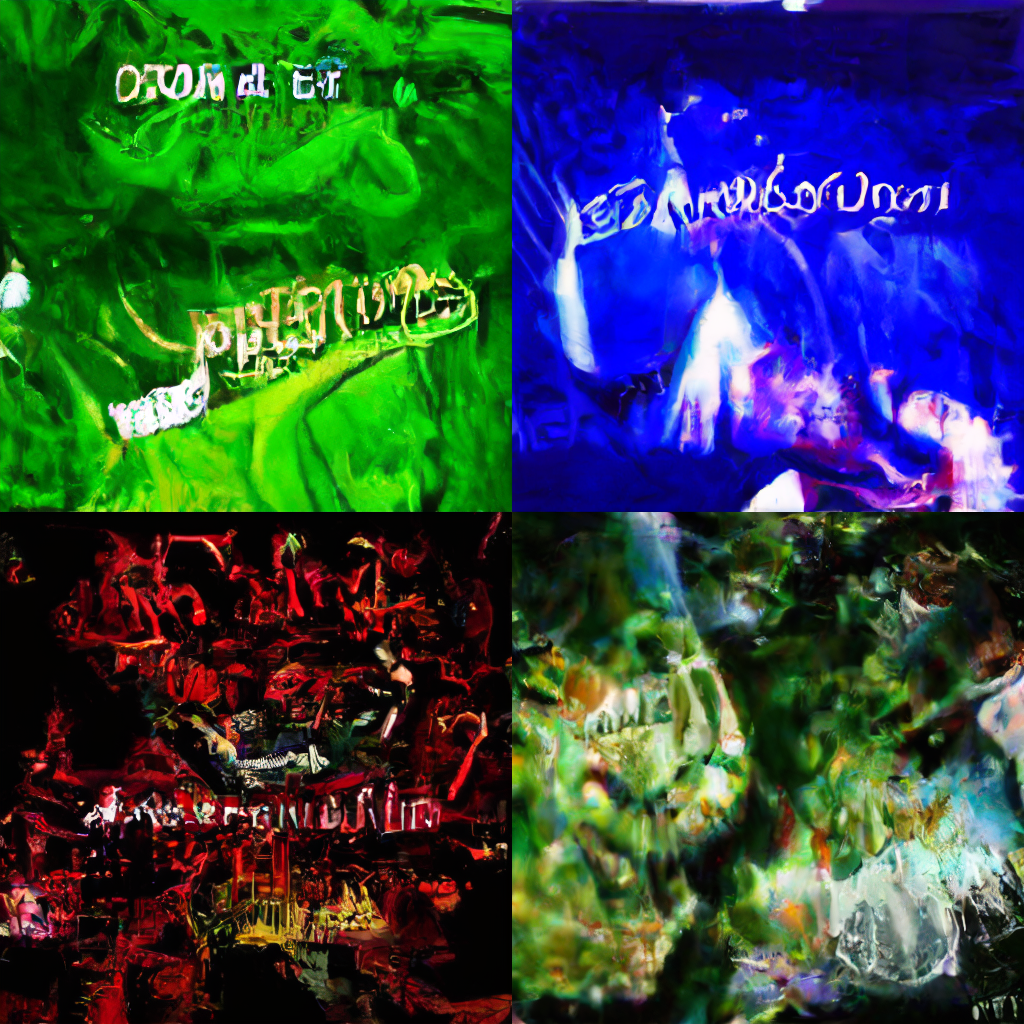

In [8]:
grid